In [1]:
import sys
import os
SPEC_PIPE_LOC = "/Users/rjassef/JPL/W12_Drops/spec_paper/Spec_pipeline"
sys.path.append(SPEC_PIPE_LOC)
os.environ['SPEC_PIPE_LOC'] = SPEC_PIPE_LOC

In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from Spec_pipeline import SDSS_Spec, Powc_Line_fit

In [3]:
#Read the spectrum.
spec = SDSS_Spec("W0116-0505", 3.173, "spec-7046-56568-0425.fits")

In [4]:
print(np.min(spec.lam_rest), np.max(spec.lam_rest))

854.7745971679688 Angstrom 2478.857666015625 Angstrom


In [5]:
#Create the model.
model = Powc_Line_fit(spec=spec)

#Add the non-polarized emission lines.
model.add_line('Lyalpha')
model.multi_line[-1].line_center[0] = 1220.*u.AA
model.add_line('Lyalpha')

#Add the polarized emission lines.
model.add_line('CIV')
model.add_line('NV')
model.add_line('SiIV-OIV]')
#model.multi_line[-1].line_center[0] = 1398.*u.AA


In [6]:
#Replace the continuum regions so that the full spectrum is used. 
full_range = np.zeros(2)*u.AA
full_range[0] = 1260.*u.AA
full_range[1] = np.max(spec.lam_rest)
model.multi_line[-1].continuum_regions[1] = full_range
model.continuum_regions

<Quantity [[1260.        , 1360.        ],
           [1260.        , 1360.        ],
           [1425.        , 1470.        ],
           [1680.        , 1705.        ],
           [1260.        , 1360.        ],
           [1300.        , 1350.        ],
           [1260.        , 2478.85766602]] Angstrom>

In [7]:
model.run_fit()

In [8]:
model.line_name = ""

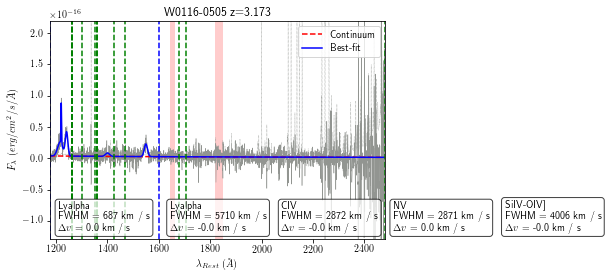

In [9]:
model.plot()

In [10]:
from synphot import SpectralElement, SourceSpectrum, Observation
from synphot.models import Empirical1D

In [11]:
#Load the filters.
R_spec = np.loadtxt("M_SPECIAL_R.txt")
I_bess = np.loadtxt("M_BESS_I.txt")
v_high = np.loadtxt("v_HIGH.txt", skiprows=2)

R_spec = R_spec[R_spec[:,1]>0.01]
I_bess = I_bess[I_bess[:,1]>0.01]
v_high = v_high[v_high[:,1]>0.01]

#Transform the wavelengths to angstroms.
R_spec[:,0] *= 10
I_bess[:,0] *= 10
v_high[:,0] *= 10

v_high = v_high[(v_high[:,0]>4000.) & (v_high[:,0]<8000.)]
I_bess = I_bess[(I_bess[:,0]>4000.) & (I_bess[:,0]<8000.)]
R_spec = R_spec[(R_spec[:,0]>4000.) & (R_spec[:,0]<8000.)]

Rbp= SpectralElement(Empirical1D, points=R_spec[:,0], lookup_table=R_spec[:,1]/100., keep_neg=False)
Ibp= SpectralElement(Empirical1D, points=I_bess[:,0], lookup_table=I_bess[:,1]/100., keep_neg=False)
vbp= SpectralElement(Empirical1D, points=v_high[:,0], lookup_table=v_high[:,1]/100., keep_neg=False)

In [12]:
#Load the observed spectrum, the continuum each of the emission lines. 

#Obs spec
full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

#Model spec
model_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=model.flam_model(spec.lam_rest), keep_neg=True)

#Continuum spec
continuum_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=model.flam_cont_model(spec.lam_rest), keep_neg=True)

#Emission lines. 
lines_spec = list()
for i in range(len(model.multi_line)):
    lines_spec.append(SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=model.multi_line[i].flam_line_model(spec.lam_rest), keep_neg=True)
)


In [13]:
flux = dict()
bands = [vbp, Rbp, Ibp]

flux['full_spec'] = np.zeros(len(bands))
for j, band in enumerate(bands): 
    obs = Observation(full_spec, band)
    flux['full_spec'][j] = obs.effstim(flux_unit='flam').value

flux['model_spec'] = np.zeros(len(bands))
for j, band in enumerate(bands): 
    obs = Observation(model_spec, band)
    flux['model_spec'][j] = obs.effstim(flux_unit='flam').value

flux['continuum'] = np.zeros(len(bands))
for j, band in enumerate(bands): 
    obs = Observation(continuum_spec, band)
    flux['continuum'][j] = obs.effstim(flux_unit='flam').value

flux['lines'] = np.zeros((len(bands), len(model.multi_line)))
for j, band in enumerate(bands):
    for i in range(len(model.multi_line)):
        obs = Observation(lines_spec[i], band)
        flux['lines'][j,i] = obs.effstim(flux_unit='flam').value


In [14]:
def model_p(x, flux, j):

    fc = flux['continuum'][j]/flux['full_spec'][j]
    fb = 0
    for i in range(2,len(flux['lines'][j])):
        fb += flux['lines'][j,i]
    fb /= flux['full_spec'][j]

    return ((x[0]*fc)**2 + (x[1]*fb)**2 + 2*x[0]*x[1]*fc*fb*np.cos(2*x[2]*u.deg))**0.5

In [18]:
#The measured values in each band. 
p_measured = np.array([0.0973, 0.1085, 0.1469])
p_unc = np.array([0.0037, 0.0022, 0.0046])

### Unconstrained Pure Gas Fit

In [15]:
def chi2(x):
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x, flux, j)
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [16]:
from scipy.optimize import minimize, LinearConstraint
x0 = np.array([0.13, 0.17, 50.])
A = np.identity(x0.shape[0])
min_vals = [0., 0., 0.]
max_vals = [1., 1., 360.]
lincon = LinearConstraint(A, min_vals, max_vals)
xopt = minimize(chi2, x0=x0, constraints=lincon)
print(xopt)
for j in range(3):
    print(model_p(xopt.x, flux,j))

     fun: 2.9545852112739967e-08
     jac: array([-0.02719959,  0.0165207 , -0.00023087])
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 0.13712536,  0.35621714, 51.86620728])
0.09730009691469726
0.10850021175115966
0.14689935607218402


Text(0, 0.5, 'Polarization fraction')

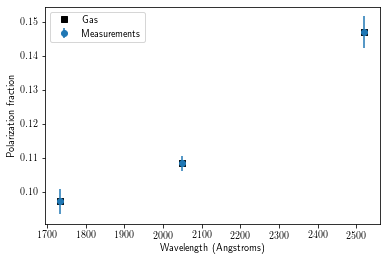

In [17]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec
plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
mod_p = np.zeros(3)
for j in range(3):
    mod_p[j] = model_p(xopt.x, flux,j)
plt.plot(wave, mod_p, 'ks', label='Gas')
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization fraction')

### Gas Fit with pol Requirement

Here we require that the emission lines and the continuum have the same polarization fraction. 

In [19]:
def chi2(x):
    p_mod = np.zeros(3)
    for j in range(3):
        x_for_model_p = [x[0], x[0], x[1]]
        p_mod[j] = model_p(x_for_model_p, flux, j)
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [23]:
from scipy.optimize import minimize, LinearConstraint
x0 = np.array([0.15, 50.])
A = np.identity(x0.shape[0])
min_vals = [0., 0.]
max_vals = [1., 360.]
lincon = LinearConstraint(A, min_vals, max_vals)
xopt = minimize(chi2, x0=x0, constraints=lincon)
print(xopt, chi2(xopt.x))
for j in range(3):
    x_for_model_p = [xopt.x[0], xopt.x[0], xopt.x[1]]
    print(model_p(x_for_model_p, flux,j))

     fun: 10.43340501750922
     jac: array([-0.05699992,  0.00025082])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.13372043, 21.74514377]) 10.43340501750922
0.08692069540475539
0.11190652898149905
0.14502272359275384


Text(0, 0.5, 'Polarization fraction')

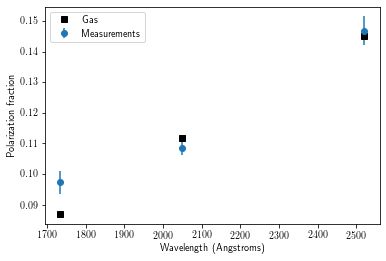

In [22]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec
plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
mod_p = np.zeros(3)
for j in range(3):
    x_for_model_p = [xopt.x[0], xopt.x[0], xopt.x[1]]
    mod_p[j] = model_p(x_for_model_p, flux,j)
plt.plot(wave, mod_p, 'ks', label='Gas')
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization fraction')